### duplicated data 처리
#### (now) income까지 다 같은 행만 제거 duplicated_1 464.47(464.38) -> 463.78(463.70)
#### max : duplicated_2 466.40(466.31)
#### avg : duplicated_3 464.50(464.42)

#### 18261보다 작아야 함

In [273]:
name = 'gbr_mlp_ensemble_scaling'

In [274]:
gbr_learning_rate = 0.05
gbr_n_estimators = 500
gbr_max_depth = 4
gbr_min_samples_split = 16 # 노드 분할을 위한 최소 샘플 수
gbr_min_samples_leaf = 16 # 리프노드 최소 샘플 수

In [275]:
# - val_lr_0.05_n_500_d_4_s_16_leaf_16

In [276]:
xgb_learning_rate = 0.1
xgb_max_depth = 4
xgb_n_estimators = 200
xgb_min_child_weight = 16

In [277]:
# - val_n_200_lr_0.1_d_4_child_16

In [278]:
mlp_activation = 'tanh'
mlp_max_iter = 127

In [279]:
import pandas as pd
import numpy as np
import random
import os

In [280]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

In [281]:
import xgboost
from xgboost import XGBRegressor

In [282]:
import sklearn
print(sklearn.__version__)

0.24.1


In [283]:
import warnings
warnings.filterwarnings('ignore')

In [284]:
import matplotlib.pyplot as plt
import seaborn as sns

In [285]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [286]:
# 'Industry_Status',
# 'Hispanic_Origin',
# 'Household_Status',
# 'Birth_Country',
# 'Birth_Country (Father)', 
# 'Birth_Country (Mother)'

In [287]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [288]:
train.columns

Index(['ID', 'Age', 'Gender', 'Education_Status', 'Employment_Status',
       'Working_Week (Yearly)', 'Industry_Status', 'Occupation_Status', 'Race',
       'Hispanic_Origin', 'Martial_Status', 'Household_Status',
       'Household_Summary', 'Citizenship', 'Birth_Country',
       'Birth_Country (Father)', 'Birth_Country (Mother)', 'Tax_Status',
       'Gains', 'Losses', 'Dividends', 'Income_Status', 'Income'],
      dtype='object')

In [289]:
features = ['Age', 'Gender', 'Education_Status', 'Employment_Status',
       'Working_Week (Yearly)', 'Industry_Status', 'Occupation_Status', 'Race',
       'Hispanic_Origin', 'Martial_Status', 'Household_Status',
       'Household_Summary', 'Citizenship', 'Birth_Country',
       'Birth_Country (Father)', 'Birth_Country (Mother)', 'Tax_Status',
       'Gains', 'Losses', 'Dividends', 'Income_Status']

In [290]:
drop_dup_1 = train.drop_duplicates(features)
len(drop_dup_1)

18320

### 학습데이터 중복 행 처리

In [291]:
features = ['Age', 'Gender', 'Education_Status', 'Employment_Status',
    'Working_Week (Yearly)', 'Industry_Status', 'Occupation_Status', 'Race',
    'Hispanic_Origin', 'Martial_Status', 'Household_Status',
    'Household_Summary', 'Citizenship', 'Birth_Country',
    'Birth_Country (Father)', 'Birth_Country (Mother)', 'Tax_Status',
    'Gains', 'Losses', 'Dividends', 'Income_Status',
    'Income' # Income 확인 여부
    ]

In [292]:
def concatenate_columns(row, features):

    columns = [row[f] for f in features]
    return ''.join(map(str, columns))

train['key'] = train.apply(concatenate_columns, axis=1, args=(features, ))

In [293]:
train['key'][0]

'63MMiddle (7-8)Full-Time4Social ServicesServicesWhite All otherMarriedHouseholderHouseholderNativeUSUSUSNonfiler000Unknown425'

In [294]:
# count = 0
# total_count = 0
# total_count_row = 0
# dup_idxs = []
# for k in set(train['key']):
#     income = train.loc[train['key']==k, 'Income']
#     l = list(income)
#     if len(l) > 1:
#         if len(np.unique(l))>=2: # 중복 존재 & income이 다른 경우
#             # train.loc[train['key']==k, 'Income'] = max(l) # max
#             train.loc[train['key']==k, 'Income'] = sum(l)/len(l) # avg

In [295]:
drop_dup_2 = train.drop_duplicates(features)
len(drop_dup_2)

18501

### drop duplicated

In [296]:
train.drop_duplicates(features, inplace=True)
train.reset_index(drop=True, inplace=True)

In [297]:
len(train)

18501

##### max로 채우기 mean(600) / std(713)

In [298]:
train.describe()

,Age,Working_Week (Yearly),Gains,Losses,Dividends,Income
count,18501.000000,18501.000000,18501.000000,18501.000000,18501.000000,18501.000000
mean,37.752284,37.739095,414.171666,43.459435,133.453813,599.213880
std,16.726767,20.720317,4307.383394,290.029113,1254.362886,710.776048
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,24.000000,0.000000,0.000000,0.000000,0.000000
50%,36.000000,52.000000,0.000000,0.000000,0.000000,505.000000
75%,48.000000,52.000000,0.000000,0.000000,0.000000,900.000000
max,90.000000,52.000000,99999.000000,4356.000000,45000.000000,9999.000000


#### 중복행 1680

### modify age (처리x)

### modify education

In [299]:
def modify_education(education):
    if education in ['Children', 'Kindergarten', 'Elementary (1-4)', 'Elementary (5-6)', 
                     'Middle (7-8)', 'High Freshman', 'High Sophomore', 
                     'High Junior', 'High Senior']:
        return 'dropout'
    elif education in ['College', 'Associates degree (Academic)', 'Associates degree (Vocational)']:
        return 'CommunityCollege'
    elif education in ['Professional degree', 'Masters degree']:
        return 'Masters degree'
    else:
        return education

In [300]:
train['Education'] = train['Education_Status']
train['Education'] = train['Education'].apply(modify_education)

In [301]:
test['Education'] = test['Education_Status']
test['Education'] = test['Education'].apply(modify_education)

### employment status

### race - 시도

### martial status

### modify household (처리x)

In [302]:
np.unique(train['Household_Summary'])

array(['Child 18 or older', 'Child under 18 ever married',
       'Child under 18 never married',
       'Group Quarters- Secondary individual', 'Householder',
       'Nonrelative of householder', 'Other relative of householder',
       'Spouse of householder'], dtype=object)

In [303]:
# def modify_household(household):
#     if household == 'Householder':
#         return 'Householder'
#     elif household in ['Child 18 or older', 'Child under 18 ever married', 'Child under 18 never married', 
#                      'Other relative of householder', 'Spouse of householder']:
#         return 'dependents'
#     else:
#         return 'others'

In [304]:
# train['Household_Summary'] = train['Household_Summary'].apply(modify_household)
# test['Household_Summary'] = test['Household_Summary'].apply(modify_household)

### citizenship

### modify tax status (처리x)

In [305]:
def modify_tax(tax):
    if tax.startswith('Married'):
        return 'MFJ'
    else:
        return tax

In [306]:
# train['Tax_Status'] = train['Tax_Status'].apply(modify_tax)
# test['Tax_Status'] = test['Tax_Status'].apply(modify_tax)

In [307]:
# sns.histplot(y='Tax_Status', data=train)

### modify income status

In [308]:
def modify_income_status(status):
    if status in ['Unknown', 'Under Median']:
        return 'Under Median'
    else:
        return status

In [309]:
train['Income_Status'] = train['Income_Status'].apply(modify_income_status)
test['Income_Status'] = test['Income_Status'].apply(modify_income_status)

In [310]:
train

,ID,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,...,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status,Income,key,Education
0,TRAIN_00000,63,M,Middle (7-8),Full-Time,4,Social Services,Services,White,All other,...,US,US,Nonfiler,0,0,0,Under Median,425,63MMiddle (7-8)Full-Time4Social ServicesServic...,dropout
1,TRAIN_00001,37,M,Associates degree (Vocational),Full-Time,52,Entertainment,Services,White,All other,...,US,US,Single,0,0,0,Under Median,0,37MAssociates degree (Vocational)Full-Time52En...,CommunityCollege
2,TRAIN_00002,58,F,High graduate,Full-Time,52,Manufacturing (Non-durable),Admin Support (include Clerical),Black,All other,...,US,US,Married Filling Jointly both under 65 (MFJ),3411,0,0,Under Median,860,58FHigh graduateFull-Time52Manufacturing (Non-...,High graduate
3,TRAIN_00003,44,M,High graduate,Full-Time,52,Retail,Technicians & Support,White,All other,...,US,US,Single,0,0,0,Under Median,850,44MHigh graduateFull-Time52RetailTechnicians &...,High graduate
4,TRAIN_00004,37,F,High graduate,Full-Time,52,Retail,Sales,White,All other,...,US,US,Head of Household (HOH),0,0,0,Under Median,570,37FHigh graduateFull-Time52RetailSalesWhite Al...,High graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18496,TRAIN_19995,33,M,High graduate,Children or Armed Forces,52,Manufacturing (Durable),Handlers/Cleaners,White,All other,...,US,US,Single,0,0,0,Under Median,1300,33MHigh graduateChildren or Armed Forces52Manu...,High graduate
18497,TRAIN_19996,20,F,College,Full-Time,12,Education,Admin Support (include Clerical),White,Mexican-American,...,Mexico,Mexico,Nonfiler,0,0,0,Under Median,850,20FCollegeFull-Time12EducationAdmin Support (i...,CommunityCollege
18498,TRAIN_19997,22,M,College,Children or Armed Forces,52,Transportation,Technicians & Support,White,All other,...,US,US,Single,0,0,0,Under Median,999,22MCollegeChildren or Armed Forces52Transporta...,CommunityCollege
18499,TRAIN_19998,76,F,High graduate,Not Working,0,Not in universe or children,Unknown,White,All other,...,Scotland,England,Single,0,0,0,Under Median,0,76FHigh graduateNot Working0Not in universe or...,High graduate


#### 노이즈 제거 (고려)

In [311]:
under = train.loc[train['Income_Status']=='Under Median']

Q1 = np.quantile(under['Income'], 0.25)
Q3 = np.quantile(under['Income'], 0.75)
IOR = Q3-Q1
outlier_step = IOR*1.5

u_outliers = under.loc[(under['Income']<Q1-outlier_step)|(under['Income']>Q3+outlier_step)]
len(u_outliers)

233

(array([154.,  18.,  12.,   8.,  10.,   8.,   4.,   9.,   4.,   6.]),
 array([2251. , 3017.5, 3784. , 4550.5, 5317. , 6083.5, 6850. , 7616.5,
        8383. , 9149.5, 9916. ]),
 <BarContainer object of 10 artists>)

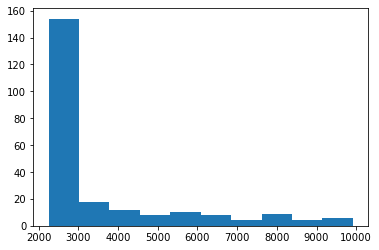

In [312]:
plt.hist(u_outliers['Income'])

In [313]:
over = train.loc[train['Income_Status']=='Over Median']

Q1 = np.quantile(over['Income'], 0.25)
Q3 = np.quantile(over['Income'], 0.75)
IOR = Q3-Q1
outlier_step = IOR*1.5

o_outliers = over.loc[(over['Income']<Q1-outlier_step)|(over['Income']>Q3+outlier_step)]
len(o_outliers)

7

(array([2., 0., 0., 3., 1., 0., 0., 0., 0., 1.]),
 array([4807. , 5326.2, 5845.4, 6364.6, 6883.8, 7403. , 7922.2, 8441.4,
        8960.6, 9479.8, 9999. ]),
 <BarContainer object of 10 artists>)

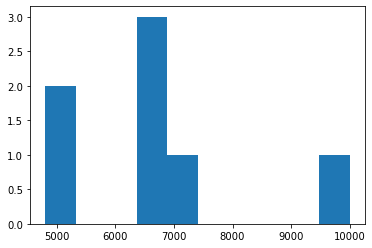

In [314]:
plt.hist(o_outliers['Income'])

In [315]:
outliers = list(u_outliers.index) + list(o_outliers.index)

In [316]:
# train.drop(index=u_outliers.index, inplace=True)
train.drop(index=outliers, inplace=True)
train.reset_index(drop=True, inplace=True)

#### outlier 231 (income state = under median)

### working week (처리x)

In [317]:
# plt.hist(train['Working_Week (Yearly)'])
# plt.show()

In [318]:
# sum(train['Working_Week (Yearly)']<52), sum(train['Working_Week (Yearly)']==52)

##### (7891, 10429)

### mod

In [319]:
# train['Working_Week (Yearly)'] = np.where(train['Working_Week (Yearly)']<52, 0, 1)
# test['Working_Week (Yearly)'] = np.where(test['Working_Week (Yearly)']<52, 0, 1)

In [320]:
# plt.hist(train['Working_Week (Yearly)'])
# plt.show()

### gain, loss, dividend (binary 처리)

In [321]:
train['Gains'] = np.where(train['Gains']>0, 1, 0)
test['Gains'] = np.where(test['Gains']>0, 1, 0)

train['Losses'] = np.where(train['Losses']>0, 1, 0)
test['Losses'] = np.where(test['Losses']>0, 1, 0)

train['Dividends'] = np.where(train['Dividends']>0, 1, 0)
test['Dividends'] = np.where(test['Dividends']>0, 1, 0)

In [322]:
# train['Capital'] = train['Gains'] + train['Dividends'] - train['Losses']
# test['Capital'] = test['Gains'] + test['Dividends'] - test['Losses']

# train['Capital'] = np.where(train['Capital']>0, 1, 0)
# test['Capital'] = np.where(test['Capital']>0, 1, 0)

### feature engineering 후 중복 확인

In [323]:
features = ['Age', 'Gender', 'Employment_Status',
       'Working_Week (Yearly)', 'Industry_Status', 'Occupation_Status', 
       'Race',
       'Martial_Status',
       'Household_Summary', 'Citizenship', 'Tax_Status',
       'Gains', 'Losses', 'Dividends', 'Income_Status',
       'Education']

In [324]:
sum(train.duplicated(features))

1208

In [325]:
# train['key'] = train.apply(concatenate_columns, axis=1, args=(features, ))

In [326]:
# count = 0
# total_count = 0
# total_count_row = 0
# dup_idxs = []
# for k in set(train['key']):
#     income = train.loc[train['key']==k, 'Income']
#     l = list(income)
#     if len(l) > 1:
#         if len(np.unique(l))>=2: # 중복 존재 & income이 다른 경우
#             # train.loc[train['key']==k, 'Income'] = max(l) # max
#             print(l)

### main

In [327]:
trainval_x = train.drop(columns=['ID', 'Income', 
                                #  'Industry_Status',
                                 'Hispanic_Origin', 
                                 'Household_Status', 
                                 'Birth_Country', 
                                 'Birth_Country (Father)', 'Birth_Country (Mother)',
                                 'Education_Status',
                                #  'Gains', 'Losses', 'Dividends',
                                 'key'
                                 ])

trainval_y = train['Income']
income_over = train['Income'] > 900
# trainval_y = np.log(train['Income']+1)

test_x = test.drop(columns=['ID',
                            # 'Industry_Status',
                            'Hispanic_Origin', 
                            'Household_Status', 
                            'Birth_Country', 
                            'Birth_Country (Father)', 'Birth_Country (Mother)',
                            'Education_Status',
                            # 'Gains', 'Losses', 'Dividends'
                            ])

In [328]:
print(np.unique(income_over, return_counts=True))

(array([False,  True]), array([13923,  4338], dtype=int64))


In [329]:
trainval_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18261 entries, 0 to 18260
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Age                    18261 non-null  int64 
 1   Gender                 18261 non-null  object
 2   Employment_Status      18261 non-null  object
 3   Working_Week (Yearly)  18261 non-null  int64 
 4   Industry_Status        18261 non-null  object
 5   Occupation_Status      18261 non-null  object
 6   Race                   18261 non-null  object
 7   Martial_Status         18261 non-null  object
 8   Household_Summary      18261 non-null  object
 9   Citizenship            18261 non-null  object
 10  Tax_Status             18261 non-null  object
 11  Gains                  18261 non-null  int32 
 12  Losses                 18261 non-null  int32 
 13  Dividends              18261 non-null  int32 
 14  Income_Status          18261 non-null  object
 15  Education          

In [330]:
print(len(trainval_x))

18261


In [331]:
encoding_target = list(trainval_x.dtypes[trainval_x.dtypes == "object"].index)

# save_encoder = None
for i in encoding_target:
    le = LabelEncoder()

    # train과 test 데이터셋에서 해당 열의 모든 값을 문자열로 변환
    trainval_x[i] = trainval_x[i].astype(str)
    test_x[i] = test_x[i].astype(str)

    le.fit(trainval_x[i])
    trainval_x[i] = le.transform(trainval_x[i])
    
    # test 데이터의 새로운 카테고리에 대해 le.classes_ 배열에 추가
    for case in np.unique(test_x[i]):
        if case not in le.classes_: 
            print('case')
            le.classes_ = np.append(le.classes_, case)
    
    test_x[i] = le.transform(test_x[i])

    # if i == 'Occupation_Status':
    #     save_encoder = le
    #     print(f'{i}_save')

    if len(np.unique(trainval_x[i])) == 2:
        print(i)
        continue

    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore') ## ignore로 학습 데이터셋에 없는 데이터가 들어와도 무시
    train_encoded = ohe.fit_transform(trainval_x[[i]])

    train_encoded_df = pd.DataFrame(train_encoded, columns=[f"{i}_{j}" for j in range(train_encoded.shape[1])])
    trainval_x = pd.concat([trainval_x.drop(columns=[i]), train_encoded_df], axis=1)
    
    test_encoded = ohe.transform(test_x[[i]])
    
    test_encoded_df = pd.DataFrame(test_encoded, columns=[f"{i}_{j}" for j in range(test_encoded.shape[1])])
    test_x = pd.concat([test_x.drop(columns=[i]), test_encoded_df], axis=1)

Gender
Income_Status


In [332]:
trainval_x.head()

,Age,Gender,Working_Week (Yearly),Gains,Losses,Dividends,Income_Status,Employment_Status_0,Employment_Status_1,Employment_Status_2,...,Tax_Status_2,Tax_Status_3,Tax_Status_4,Tax_Status_5,Education_0,Education_1,Education_2,Education_3,Education_4,Education_5
0,63,1,4,0,0,0,1,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,37,1,52,0,0,0,1,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,58,0,52,1,0,0,1,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,44,1,52,0,0,0,1,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,37,0,52,0,0,0,1,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [333]:
len(trainval_x.columns)

91

In [334]:
len(train), len(trainval_x), len(income_over)

(18261, 18261, 18261)

In [335]:
kf = StratifiedKFold(n_splits=5, shuffle=True)

### train

#### ensemble try

In [336]:
numeric_cols = ['Age', 'Working_Week (Yearly)']

In [337]:
num_fold = 1
total_train_error_gbr, total_val_error_gbr = 0, 0
total_train_error_xgb, total_val_error_xgb = 0, 0
total_train_error_mlp, total_val_error_mlp = 0, 0
total_train_error, total_val_error = 0, 0
test_preds = []
for train_idx, val_idx in kf.split(trainval_x, income_over):
    train_x = trainval_x.iloc[train_idx]
    train_y = trainval_y.iloc[train_idx]
    # print(train_x.shape)

    val_x = trainval_x.iloc[val_idx]
    val_y = trainval_y.iloc[val_idx]

    fold_train_y_preds = []
    fold_val_y_preds = []

    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    train_y_scaled = scaler_y.fit_transform(train_y.values.reshape(-1,1)).squeeze()

    ## gbr
    gbr = GradientBoostingRegressor(learning_rate = gbr_learning_rate,
                                    n_estimators = gbr_n_estimators,
                                    max_depth = gbr_max_depth,
                                    min_samples_split = gbr_min_samples_split, # 노드 분할을 위한 최소 샘플 수
                                    min_samples_leaf = gbr_min_samples_leaf # 리프노드 최소 샘플 수
                                    )
    gbr.fit(train_x, train_y_scaled)

    # with open(f'{model_path}/gbr_{num_fold}.pkl', 'wb') as f:
    #     pickle.dump(gbr, f)

    train_y_hat_gbr = gbr.predict(train_x)
    val_y_hat_gbr = gbr.predict(val_x)

    train_y_hat_gbr_inverse = scaler_y.inverse_transform(train_y_hat_gbr.reshape(-1,1)).squeeze()
    val_y_hat_gbr_inverse = scaler_y.inverse_transform(val_y_hat_gbr.reshape(-1,1)).squeeze()

    fold_train_y_preds.append(train_y_hat_gbr_inverse)
    fold_val_y_preds.append(val_y_hat_gbr_inverse)

    pred_gbr = gbr.predict(test_x)
    pred_gbr_inverse = scaler_y.inverse_transform(pred_gbr.reshape(-1,1)).squeeze()

    test_preds.append(pred_gbr_inverse)

    train_error = mean_squared_error(train_y, train_y_hat_gbr_inverse) ** 0.5
    val_error = mean_squared_error(val_y, val_y_hat_gbr_inverse) ** 0.5

    total_train_error_gbr += train_error
    total_val_error_gbr += val_error

    print(f'[gbr] train error : {train_error:.2f} | val error : {val_error:.2f}')
    ####################################################################################
    
    ## xgb
    # xgb = XGBRegressor(learning_rate = xgb_learning_rate,
    #                     max_depth = xgb_max_depth,
    #                     n_estimators = xgb_n_estimators,
    #                     min_child_weight = xgb_min_child_weight
    #                     )
    # xgb.fit(train_x, train_y_scaled)

    # # with open(f'{model_path}/xgb_{num_fold}.pkl', 'wb') as f:
    # #     pickle.dump(xgb, f)

    # train_y_hat_xgb = xgb.predict(train_x)
    # val_y_hat_xgb = xgb.predict(val_x)

    # train_y_hat_xgb_inverse = scaler_y.inverse_transform(train_y_hat_xgb.reshape(-1,1)).squeeze()
    # val_y_hat_xgb_inverse = scaler_y.inverse_transform(val_y_hat_xgb.reshape(-1,1)).squeeze()

    # fold_train_y_preds.append(train_y_hat_xgb_inverse)
    # fold_val_y_preds.append(val_y_hat_xgb_inverse)

    # pred_xgb = xgb.predict(test_x)
    # pred_xgb_inverse = scaler_y.inverse_transform(pred_xgb.reshape(-1,1)).squeeze()

    # test_preds.append(pred_xgb_inverse)

    # train_error = mean_squared_error(train_y, train_y_hat_xgb_inverse) ** 0.5
    # val_error = mean_squared_error(val_y, val_y_hat_xgb_inverse) ** 0.5

    # total_train_error_xgb += train_error
    # total_val_error_xgb += val_error

    # print(f'[xgb] train error : {train_error:.2f} | val error : {val_error:.2f}')    
    ####################################################################################
 
    ## mlp
    mlp = MLPRegressor(activation=mlp_activation, 
                       max_iter=mlp_max_iter,
                       )
    mlp.fit(train_x, train_y_scaled)

    # with open(f'{model_path}/mlp_{num_fold}.pkl', 'wb') as f:
    #     pickle.dump(mlp, f)

    train_y_hat_mlp = mlp.predict(train_x)
    val_y_hat_mlp = mlp.predict(val_x)

    train_y_hat_mlp_inverse = scaler_y.inverse_transform(train_y_hat_mlp.reshape(-1,1)).squeeze()
    val_y_hat_mlp_inverse = scaler_y.inverse_transform(val_y_hat_mlp.reshape(-1,1)).squeeze()

    fold_train_y_preds.append(train_y_hat_mlp_inverse)
    fold_val_y_preds.append(val_y_hat_mlp_inverse)

    pred_mlp = mlp.predict(test_x)
    pred_mlp_inverse = scaler_y.inverse_transform(pred_mlp.reshape(-1,1)).squeeze()

    test_preds.append(pred_mlp_inverse)

    train_error = mean_squared_error(train_y, train_y_hat_mlp_inverse) ** 0.5
    val_error = mean_squared_error(val_y, val_y_hat_mlp_inverse) ** 0.5

    total_train_error_mlp += train_error
    total_val_error_mlp += val_error

    print(f'[mlp] train error : {train_error:.2f} | val error : {val_error:.2f}')
    ####################################################################################

    fold_train_y_hat = np.array(fold_train_y_preds).mean(0)
    fold_val_y_hat = np.array(fold_val_y_preds).mean(0)
    
    train_error = mean_squared_error(train_y, fold_train_y_hat) ** 0.5
    val_error = mean_squared_error(val_y, fold_val_y_hat) ** 0.5

    total_train_error += train_error
    total_val_error += val_error

    print(f'[mean] train error : {train_error:.2f} | val error : {val_error:.2f}')    
    print('-'*50)

    num_fold += 1

[gbr] train error : 431.92 | val error : 462.97
[mlp] train error : 413.28 | val error : 486.94
[mean] train error : 415.96 | val error : 468.59
--------------------------------------------------
[gbr] train error : 431.01 | val error : 468.43
[mlp] train error : 439.74 | val error : 481.26
[mean] train error : 431.09 | val error : 470.68
--------------------------------------------------


In [ ]:
len(test_preds)

10

In [ ]:
print(f'final train error gbr : {total_train_error_gbr/5:.2f}')
print(f'final val error gbr : {total_val_error_gbr/5:.2f}')

print(f'final train error xgb : {total_train_error_xgb/5:.2f}')
print(f'final val error xgb : {total_val_error_xgb/5:.2f}')

print(f'final train error mlp : {total_train_error_mlp/5:.2f}')
print(f'final val error mlp : {total_val_error_mlp/5:.2f}')

print(f'[total] final train error : {total_train_error/5:.2f}')
print(f'[total] final val error : {total_val_error/5:.2f}')

final train error gbr : 432.61
final val error gbr : 461.81
final train error xgb : 0.00
final val error xgb : 0.00
final train error mlp : 414.29
final val error mlp : 481.86
[total] final train error : 416.30
[total] final val error : 464.86


#### 459.16 [xgb + mlp]

#### 459.31 [gbr + mlp]

#### 459.31 [gbr + xgb + mlp]

#### 461.32 [gbr + xgb]

#### 원래 메인

In [ ]:
# num_fold = 1
# total_train_error, total_val_error = 0, 0
# total_train_error_post, total_val_error_post = 0, 0
# test_preds = []
# for train_idx, val_idx in kf.split(trainval_x, income_over):
#     train_x = trainval_x.iloc[train_idx]
#     train_y = trainval_y.iloc[train_idx]

#     val_x = trainval_x.iloc[val_idx]
#     val_y = trainval_y.iloc[val_idx]

#     model = GradientBoostingRegressor(max_depth=4)
#     # model.fit(train_x, train_y)
#     model.fit(train_x, train_y)

#     print(f'{num_fold} fold')

#     train_y_hat = model.predict(train_x)
#     val_y_hat = model.predict(val_x)

#     pred = model.predict(test_x)

#     test_preds.append(pred)

#     train_error = mean_squared_error(train_y, train_y_hat) ** 0.5
#     val_error = mean_squared_error(val_y, val_y_hat) ** 0.5

#     total_train_error += train_error
#     total_val_error += val_error

#     train_y_hat_post = np.where(train_y_hat<0, 0, train_y_hat)
#     val_y_hat_post = np.where(val_y_hat<0, 0, val_y_hat)

#     train_error_post = mean_squared_error(train_y, train_y_hat_post) ** 0.5
#     val_error_post = mean_squared_error(val_y, val_y_hat_post) ** 0.5

#     total_train_error_post += train_error_post
#     total_val_error_post += val_error_post

#     print(f'train error : {train_error:.2f} | val error : {val_error:.2f}')
#     print(f'[post] train error : {train_error_post:.2f} | val error : {val_error_post:.2f}')
    
#     print('-'*30)

#     # feature_importances = model.feature_importances_
#     # importance_df = pd.Series(feature_importances[:20], index=trainval_x.columns[:20])
#     # importance_df.sort_values(inplace=True)

#     # plt.barh(np.arange(len(importance_df)), importance_df)
#     # plt.yticks(np.arange(len(importance_df)), importance_df.index)
#     # plt.show()

#     num_fold += 1

In [ ]:
# print(f'final train error : {total_train_error/5:.2f}')
# print(f'final val error : {total_val_error/5:.2f}')

# print(f'[post] final train error : {total_train_error_post/5:.2f}')
# print(f'[post] final val error : {total_val_error_post/5:.2f}')

In [ ]:
final_pred = np.array(test_preds).mean(0)

In [ ]:
final_pred_post = np.where(final_pred<0, 0, final_pred)

In [ ]:
# final_pred_exp = np.exp(final_pred)-1

In [ ]:
submission = pd.read_csv('data/sample_submission.csv')

In [ ]:
submission['Income'] = final_pred
submission['Income'] = final_pred_post
# submission['Income'] = final_pred_exp
submission

,ID,Income
0,TEST_0000,0.000000
1,TEST_0001,0.000000
2,TEST_0002,327.718292
3,TEST_0003,552.510527
4,TEST_0004,0.000000
...,...,...
9995,TEST_9995,831.275598
9996,TEST_9996,680.140439
9997,TEST_9997,394.694875
9998,TEST_9998,0.000000


In [ ]:
os.makedirs('submission', exist_ok=True)
submission.to_csv(f'submission/{name}.csv', index=False)

(array([322., 199., 136.,  72.,  48.,  32.,  15.,   3.,   2.,   5.]),
 array([1000.05179309, 1079.61441964, 1159.17704619, 1238.73967274,
        1318.30229929, 1397.86492584, 1477.42755239, 1556.99017894,
        1636.55280549, 1716.11543204, 1795.67805859]),
 <BarContainer object of 10 artists>)

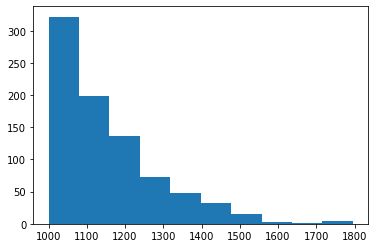

In [ ]:
plt.hist(final_pred_post[final_pred_post>1000])

(array([1507.,  945.,  624.,  323.,   63.,   21.,   10.,    9.,    2.,
           4.]),
 array([1001. , 1300.9, 1600.8, 1900.7, 2200.6, 2500.5, 2800.4, 3100.3,
        3400.2, 3700.1, 4000. ]),
 <BarContainer object of 10 artists>)

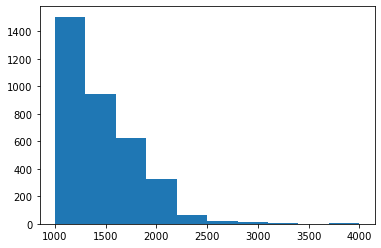

In [ ]:
plt.hist(train.loc[train['Income']>1000, 'Income'])